#BERT

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import torch
from torch import nn
import matplotlib.pyplot as plt

# импортируем трансформеры
import transformers
from transformers import AdamW
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
import source.train_rnn_aa as train_rnn_aa

from torch.utils.data import DataLoader, TensorDataset, DataLoader, RandomSampler
from sklearn.utils.class_weight import compute_class_weight
from torchmetrics.classification import BinaryAccuracy

#some useful lybs
import random as random

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


/home/andrey/Documents/venv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# читаемм данные
train_df = pd.read_csv('data/short_set.csv', index_col=0)
train_df.head()

,text,label
0,Классный мастер. Огромное спасибо за чудесное ...,1
1,Замечательный врач. Хочу выразить особую благо...,1
2,Благодарность работникам рентгена. Добрый вече...,1
3,Доктор Рабинович. Женщины советского образца в...,0
4,Есть кому сказать спасибо. У меня с детства оч...,1


In [3]:
train_df['label'] = train_df['label'].astype(float)
train_df.head()

,text,label
0,Классный мастер. Огромное спасибо за чудесное ...,1.0
1,Замечательный врач. Хочу выразить особую благо...,1.0
2,Благодарность работникам рентгена. Добрый вече...,1.0
3,Доктор Рабинович. Женщины советского образца в...,0.0
4,Есть кому сказать спасибо. У меня с детства оч...,1.0


In [4]:
train_df = train_df.rename(columns={'text':'content', 'label':'class'})

In [5]:
# ! comment it when ready !!!!

# limit the set for models setup time
#data_limit = 0.04 # to 4% of original length
#data_len = len(train_df)-1
#a_len = round(data_len * data_limit)
#
#a = [random.randint(0, data_len) for i in range(a_len)] 
#train_df = train_df.iloc[ a , : ].reset_index(drop=True)
#len(train_df) # 7060 records -> 10%
#4% -> 

In [6]:
train_df.head()

,content,class
0,Классный мастер. Огромное спасибо за чудесное ...,1.0
1,Замечательный врач. Хочу выразить особую благо...,1.0
2,Благодарность работникам рентгена. Добрый вече...,1.0
3,Доктор Рабинович. Женщины советского образца в...,0.0
4,Есть кому сказать спасибо. У меня с детства оч...,1.0


In [7]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
CUDA_VISIBLE_DEVICES = 0,1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
# https://huggingface.co/google-bert/bert-base-uncased
# подгружаем токенизатор и модель
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
local_bert = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

(array([44934., 16994.,  4948.,  1871.,   835.,   413.,   221.,   147.,
          144.,    90.]),
 array([  3. ,  89.8, 176.6, 263.4, 350.2, 437. , 523.8, 610.6, 697.4,
        784.2, 871. ]),
 <BarContainer object of 10 artists>)

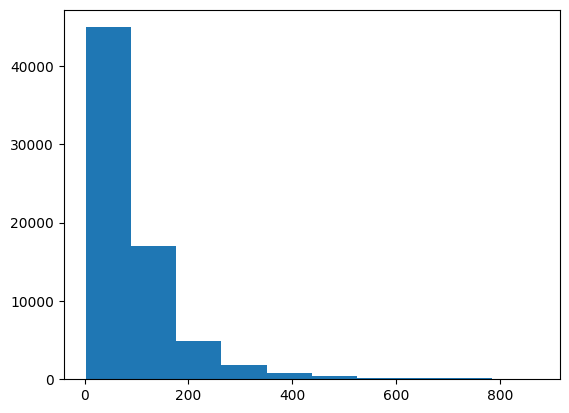

In [9]:
# words number in set
train_lens = [len(i.split()) for i in train_df['content']]
plt.hist(train_lens)

In [10]:
SEQ_LEN = 550 #2048 max
BATCH_SIZE = 256

In [11]:
train_df, test_df, train_labels, test_labels = train_test_split(train_df['content'], train_df['class'], 
                                                                    random_state=99, 
                                                                    test_size=0.15)

In [12]:
tokens_train_df = tokenizer.batch_encode_plus(train_df.tolist(), max_length = SEQ_LEN, pad_to_max_length=True, truncation=True)

In [13]:
tokens_test_df = tokenizer.batch_encode_plus(test_df.tolist(), max_length = SEQ_LEN, pad_to_max_length=True, truncation=True)

In [14]:
train_X_tenzor = torch.tensor(tokens_train_df['input_ids'])
train_mask_tenzor = torch.tensor(tokens_train_df['attention_mask'])
train_y_tenzor = torch.from_numpy(np.array(train_labels))

test_X_tenzor = torch.tensor(tokens_test_df['input_ids'])
test_mask_tenzor = torch.tensor(tokens_test_df['attention_mask'])
test_y_tenzor = torch.from_numpy(np.array(test_labels))

In [15]:
train_data = TensorDataset(train_X_tenzor, train_mask_tenzor, train_y_tenzor)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)

In [16]:
test_data = TensorDataset(test_X_tenzor, test_mask_tenzor, test_y_tenzor)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [17]:
#freeze it
for param in local_bert.parameters():
    param.requires_grad = False

In [18]:
class BERT_architecture(nn.Module):
    def __init__(self, bert):     
      super(BERT_architecture, self).__init__()
      self.bert = bert 
      # dropout layer
      self.dropout = nn.Dropout()      
      self.tahn = nn.Tanh()
      self.Sigmoid1 = nn.Sigmoid()
      self.Sigmoid2 = nn.Sigmoid()
      self.fc1 = nn.Linear(312,256)
      self.fc2 = nn.Linear(256,100)
      self.fc3 = nn.Linear(100,32)
      self.fc4 = nn.Linear(32,1)
      #self.fc3 = nn.Linear(64,5)

      self.softmax = nn.LogSoftmax(dim=1)
      
    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) 
      cls_hs = nn.functional.normalize(cls_hs)
      #print(f'cls : {cls_hs.shape}')  #cls : torch.Size([64, 312])
      x = self.fc1(cls_hs)
      x = self.Sigmoid1(x)
      x = self.dropout(x)

      x = self.fc2(x)
      x = self.Sigmoid2(x)

      x = self.fc3(x)
      x = self.Sigmoid2(x)
      x = self.fc4(x)
      x = self.Sigmoid2(x)
      return x

#Epoch 1, time spent: 5.22
#train_loss : 0.1578 val_loss : 0.1602
#train_accuracy : 0.94 val_accuracy : 0.94

In [19]:
model = BERT_architecture(local_bert)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): BERT_architecture(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(83828, 312, padding_idx=0)
        (position_embeddings): Embedding(2048, 312)
        (token_type_embeddings): Embedding(2, 312)
        (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-2): 3 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=312, out_features=312, bias=True)
                (key): Linear(in_features=312, out_features=312, bias=True)
                (value): Linear(in_features=312, out_features=312, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=312, out_features=312, bias=True

In [20]:
#optimizer = AdamW(model.parameters(),lr = 0.01)  # learning rate
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.01)  # learning rate

In [21]:
#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels 
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_labels)))

class weights are [1.21614446 0.84909158] for [0. 1.]


In [22]:
weights= torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)

#criterion  = nn.CrossEntropyLoss(weight=weights) 
#criterion  = nn.CrossEntropyLoss() 
#criterion  = nn.BCELoss(weight=weights) 
#criterion  = nn.BCELoss() 
criterion  = nn.BCEWithLogitsLoss() 

metric = BinaryAccuracy()

In [23]:
#train_rnn_aa
epoch_train_losses = [] 
epoch_valid_losses = [] 
epoch_train_metric = [] 
epoch_valid_metric = [] 
time_spent = [] 

In [24]:
privet()

NameError: name 'privet' is not defined

In [27]:
model, epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, time_spent = train_rnn_aa.train_BERT(25, model, 
        train_dataloader,
        test_dataloader, 
        optimizer, 
        criterion,   
        metric,              
        epoch_train_losses,
        epoch_valid_losses,
        epoch_train_metric,
        epoch_valid_metric,
        time_spent, device)

Epoch 1, time spent: 130.21
train_loss : 0.5025 val_loss : 0.5039
train_accuracy : 0.93 val_accuracy : 0.93
Epoch 2, time spent: 129.81
train_loss : 0.5029 val_loss : 0.5053
train_accuracy : 0.92 val_accuracy : 0.93
Epoch 3, time spent: 130.27
train_loss : 0.5029 val_loss : 0.5049
train_accuracy : 0.93 val_accuracy : 0.94
Epoch 4, time spent: 130.39
train_loss : 0.5025 val_loss : 0.5042
train_accuracy : 0.93 val_accuracy : 0.94
Epoch 5, time spent: 130.37
train_loss : 0.5023 val_loss : 0.5049
train_accuracy : 0.92 val_accuracy : 0.94
Epoch 6, time spent: 130.55
train_loss : 0.5024 val_loss : 0.5064
train_accuracy : 0.93 val_accuracy : 0.92
Epoch 7, time spent: 132.17
train_loss : 0.5020 val_loss : 0.5043
train_accuracy : 0.93 val_accuracy : 0.94
Epoch 8, time spent: 130.52
train_loss : 0.5018 val_loss : 0.5037
train_accuracy : 0.93 val_accuracy : 0.94
Epoch 9, time spent: 130.50
train_loss : 0.5017 val_loss : 0.5038
train_accuracy : 0.93 val_accuracy : 0.93
Epoch 10, time spent: 130.34

In [28]:
torch.save(model, 'models/model_bert.mod')

In [29]:
res = pd.DataFrame.from_dict({'epoch_train_losses':epoch_train_losses, 
                              'epoch_valid_losses': epoch_valid_losses, 
                              'epoch_train_metric': epoch_train_metric, 
                              'epoch_valid_metric': epoch_valid_metric, 
                               'time_spent': time_spent })

In [30]:
res.head()

,epoch_train_losses,epoch_valid_losses,epoch_train_metric,epoch_valid_metric,time_spent
0,0.525405,0.508971,0.871188,0.922510,134.272626
1,0.511260,0.509225,0.905787,0.927812,129.507887
2,0.508636,0.509464,0.912229,0.929393,129.753993
3,0.508153,0.511557,0.913599,0.926933,130.030416
4,0.507701,0.506522,0.914089,0.930323,130.200960


In [31]:
res.to_csv('data/result_bert.csv')

In [ ]:
#tokens_test_df['input_ids']
#test_mask_tenzor = torch.tensor(tokens_test_df['attention_mask'])

In [35]:
answer = []
for batch_valid in test_dataloader:
            batch_valid = [r.to(device) for r in batch_valid]            
            inputs, mask, labels = batch_valid            
            
            with torch.no_grad():
                output = model(inputs, mask).squeeze()
            answer.append(output.to('cpu').squeeze())
            #answer.append(output.to('cpu').squeeze().argmax(axis=1))

In [36]:
answer_list = []
for i in range(0, len(answer)):
    answer_list.append(answer[i].tolist())

In [38]:
flat_answer_list = []
for i in answer_list:
    for j in range(0, len(i)):
        flat_answer_list.append(i[j])
len(flat_answer_list)

10590

In [39]:
answer_df = pd.DataFrame.from_dict({'answer':flat_answer_list})
answer_df['answer'] = answer_df['answer'].astype(int)
answer_df.head()

,answer
0,0
1,0
2,0
3,0
4,0


In [40]:
test_labels = test_labels.astype(int)
test_labels

2929     0
41238    1
29580    0
1844     1
26928    1
        ..
32580    1
48676    1
53790    1
49096    0
26574    1
Name: class, Length: 10590, dtype: int64

In [41]:
result = pd.DataFrame([], columns = ['Model', 'time_sec', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [42]:
accuracy = accuracy_score(test_labels, answer_df['answer'])
precision = precision_score(test_labels, answer_df['answer'], average='macro')
recall = recall_score(test_labels, answer_df['answer'], average='macro')
f1 = f1_score(test_labels, answer_df['answer'], average='macro')

In [43]:
result = pd.concat([pd.DataFrame([{'Model':'12A: BERT', 
                                   'time_sec' : f'{sum(time_spent):.1f}', 
                                   'Accuracy' : f'{accuracy:.4f}', 
                                   'Precision' : f'{precision:.4f}', 
                                   'Recall' : f'{recall:.4f}', 
                                   'F1' : f'{f1:.4f}'
                                   }],
                                   columns=result.columns), result], axis=0, ignore_index=True)

In [44]:
result.head()

,Model,time_sec,Accuracy,Precision,Recall,F1
0,12A: BERT,7185.4,0.4256,0.2128,0.5000,0.2985


In [45]:
# save results to file
result.to_csv('data/bert_model_results.csv')